# Structured Bayesian Optimisation with Pyro
## Testing performance

Goal: compare performances of standard BO-GP, random GP and SBO-GP strategies to minimize Branin-Hoo and hyperbolic functions with pyro.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
from torch.distributions import constraints, transform_to
import torch.optim as optim
import torch.autograd as autograd

import pyro
import pyro.distributions as dist
import pyro.contrib.gp as gp
from pyro.nn import PyroSample, PyroModule
from pyro.infer import autoguide, SVI, Trace_ELBO

In [2]:
print(torch.__version__)
print(pyro.__version__)

1.3.0.post2
1.0.0


### Setting random seed

In [3]:
seed_number = 555

def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
set_random_seed(seed_number)

### Minimalistic (S)BO approach

#### Acquisition function

In [4]:
def lower_confidence_bound(model, x, kappa=2):
    """ Lower Confidence Bound (LCB): $\alpha(x)=\mu(x) - \kappa\sigma(x)$ """
    
    mu, variance = model(x)
    sigma = variance.sqrt()
    
    return mu - kappa * sigma

normal_phi = lambda x: torch.exp(-x.pow(2)/2)/np.sqrt(2*np.pi)
normal_Phi = lambda x: (1 + torch.erf(x / np.sqrt(2))) / 2

def expected_improvement(model, x):
    """ Brooks' implementation of expected improvement (EI). """
    
    y_min = model.y.min()
    mu, variance = model(x)
    sigma = variance.sqrt()
    delta = y_min - mu
    EI = delta.clamp_min(0.0) + sigma*normal_phi(delta/sigma) - delta.abs()*normal_Phi(delta/sigma)
    
    return -EI

def acquisition_func(model, x, af='EI'):
    """ Defines acquisition function. """

    if af == "EI":
        return expected_improvement(model, x)
    elif af == "LCB":
        return lower_confidence_bound(model, x)
    else:
        return None

#### Model training

In [5]:
def train(model, num_steps=1000, adam_params={"lr":0.1}):
    """ Trains the semi-parametric model. """
    
    # TODO: check if param store needs to be cleared here.
    pyro.clear_param_store()
    # setup the inference algorithm
    guide = autoguide.AutoMultivariateNormal(model.model)
    optimizer = pyro.optim.Adam(adam_params)
    loss = Trace_ELBO()
    svi = SVI(model.model, guide, optimizer, loss)
    # do gradient steps
    losses = []
    for _ in range(num_steps):
        losses.append(svi.step())
    
    return losses, guide

def train_gp(model, num_steps=1000, adam_params={"lr":0.1}):
    """ Trains the gp model. """
    
    optimizer = torch.optim.Adam(model.parameters(), lr=adam_params['lr'])
    loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss
    losses = gp.util.train(model, optimizer, loss_fn, num_steps=num_steps)

    return losses, None 

#### Finding new candidates

In [6]:
def find_a_candidate(model, x_init, constr, num_steps=1000, lr=0.1):
    """ Finds new candidate """
    
    def transf_values(values, constr, dims, inv_mode=False):
        """ Transforming (un)constrained variables to (un)constrained domain """
        
        x_tmp = ()
        for i in range(dims):
            if inv_mode:
                x_tmp += (transform_to(constr[i]).inv(values[:, i]), )
            else:
                x_tmp += (transform_to(constr[i])(values[:, i]), )
            
        x = torch.stack(x_tmp, dim=1)
        return x
            
    x_dims = x_init.shape[-1]
    
    x_uncon_init = transf_values(x_init, constr, x_dims, inv_mode=True)
    x_uncon = x_uncon_init.clone().detach().requires_grad_(True)
    
    # unconstrained minimiser 
    # TODO: at the moment we are using torch optimizer, should we change to pyro?
    
    minimizer = optim.Adam([x_uncon], lr=lr)
    
    #minimizer = optim.LBFGS([x_uncon], line_search_fn='strong_wolfe')
    
    def closure():
        minimizer.zero_grad()
        x = transf_values(x_uncon, constr, x_dims)
        y = acquisition_func(model, x)
        autograd.backward(x_uncon, autograd.grad(y, x_uncon))      
        return y
    
    for _ in range(1000):
        minimizer.step(closure)
   
    x = transf_values(x_uncon, constr, x_dims)
    
    return x.detach()

In [7]:
def next_x(model, constr, num_candidates=5, num_steps=1000, lr=0.1):
    """ Finds the next best candidate on the acquisition function surface """
    
    candidates = []
    values = []
    
    # start with last step
    x_init = model.X[-1:]
    for i in range(num_candidates):

        x = find_a_candidate(model, x_init, constr, num_steps=num_steps, lr=lr)
        y = acquisition_func(model, x)
    
        candidates.append(x)
        values.append(y)
        
        # a new random attempt initial point
        x_init = torch.stack((
                x[:,0].new_empty(1).uniform_(const_x1_min, const_x1_max),
                x[:,1].new_empty(1).uniform_(const_x2_min, const_x2_max)), dim=1)
        
    argmin = torch.min(torch.cat(values), dim=0)[1].item()
        
    return candidates[argmin]

#### Updating posterior

In [8]:
def update_posterior(model, obj_function, x_new, num_steps=1000, adam_params={"lr":0.1}, 
                    gp_mode=False):
    
    # evaluate f at new point
    bh_y = obj_function(x_new) 
        
    # incorporate new evaluation
    model.X = torch.cat([model.X, x_new]) 
    model.y = torch.cat([model.y, bh_y])
    
    if not gp_mode:
        losses, guide = train(model, num_steps=num_steps, adam_params=adam_params)
    else:
        losses, guide = train_gp(model, num_steps=num_steps, adam_params=adam_params)
    
    return guide

### Helper functions

In [9]:
def plot_obj(obj_function):

    steps = 1000
    strides = 200

    X1 = torch.linspace(const_x1_min, const_x1_max, steps)
    X2 = torch.linspace(const_x2_min, const_x2_max, steps)

    X1_mesh, X2_mesh = torch.meshgrid(X1, X2)
    
    Z_mesh = obj_function(torch.stack((X1_mesh.flatten(), X2_mesh.flatten()), dim=1)).reshape(steps, steps)
    plt.contour(
        X1_mesh.detach().numpy(), 
        X2_mesh.detach().numpy(), 
        Z_mesh.detach().numpy(), strides)
    
    plt.colorbar()

In [10]:
def find_best_solution(xmins, target_lms):
    closest_dist = np.inf
    closest_point = None
    
    for xmin in xmins:
        for bh_lm in target_lms:
            dist = np.linalg.norm(xmin-bh_lm)
            if dist < closest_dist: 
                closest_dist = dist
                closest_point = xmin
                
    return closest_point, closest_dist

# Branin-Hoo example

In [11]:
const_x1_min = -5
const_x1_max = 10

const_x2_min = 0
const_x2_max = 15

# Creating constraints
constr = [
    constraints.interval(const_x1_min, const_x1_max),
    constraints.interval(const_x2_min, const_x2_max)
]

def branin_hoo(x):
    """ Compute Branin-Hoo function for fixed constants """
    a = 1.0
    b = 5.1 / (4 * np.pi**2)
    c = 5.0 / np.pi
    r = 6.0
    s = 10.0
    t = 1.0 / (8 * np.pi)
    x1 = x[...,0]
    x2 = x[...,1]
    return a * (x2 - b*x1**2 + c*x1 - r)**2 + s*(1 - t)*torch.cos(x1) + s

# Checking LMs
branin_hoo_lms = torch.stack(
    (torch.tensor([-math.pi, math.pi, 9.42478]), 
     torch.tensor([12.275, 2.275, 2.475])), dim=1)

branin_hoo_lms_np = np.stack(
    (np.array([-math.pi, math.pi, 9.42478]), 
     np.array([12.275, 2.275, 2.475])), axis=1)

assert np.allclose(branin_hoo(branin_hoo_lms).numpy(),
        np.array([0.397887, 0.397887, 0.397887], dtype=np.float32), rtol=1e-6)

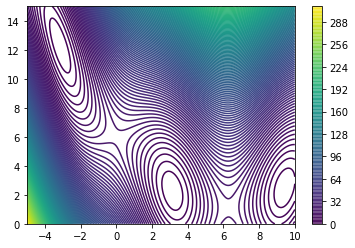

In [12]:
plot_obj(branin_hoo)

## Parameters

In [13]:
set_random_seed(555)

# Training points
N_train = 10
X_train = torch.rand(N_train, 2)*15 + torch.FloatTensor([const_x1_min, const_x2_min])
y_train = branin_hoo(X_train)

# Optimiser parameters
adam_num_steps = 1000 # 8000
adam_params={"lr":0.1} # 0.005

num_candidates = 10

bo_steps = 2

num_tests = 1

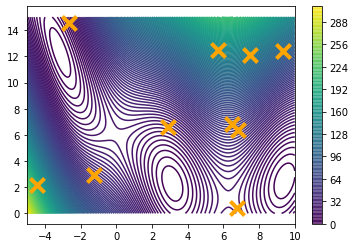

In [14]:
# Initial points
plot_obj(branin_hoo)
plt.scatter(X_train[:,0].detach().numpy(), X_train[:,1].detach().numpy(), marker="x", s=200, c='orange', zorder=2, linewidth=4);

## Analysing BO step by step

In [ ]:
set_random_seed(123)

pyro.clear_param_store()

# Training 
gp_model_svi = gp.models.GPRegression(X_train, y_train, 
                                      gp.kernels.Matern52(input_dim=X_train.shape[1], 
                                                          lengthscale=100*torch.ones(X_train.shape[1])))

# Set priors
gp_model_svi.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(3, 1).expand([2]).to_event())
gp_model_svi.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(5, 2))
gp_model_svi.noise = pyro.nn.PyroSample(dist.LogNormal(0, 1))

# Set guides
gp_model_svi.kernel.autoguide("lengthscale", dist.Normal)
gp_model_svi.kernel.autoguide("variance", dist.Normal)
gp_model_svi.autoguide("noise", dist.Normal)

# optimise
losses, _ = train_gp(gp_model_svi, num_steps=adam_num_steps, adam_params=adam_params)

In [ ]:
plt.semilogy(losses);

In [ ]:
for i in range(3):
    
    plt.figure(figsize=(15, 3)) 
    with torch.no_grad(), gp_model_svi._pyro_context:
        plt.subplot(1,3,1)
        plt.title("EI")
        f = lambda x: acquisition_func(gp_model_svi, x)
        plot_obj(f)

        plt.subplot(1,3,2)
        plt.title("GP mean")
        f = lambda x: gp_model_svi(x)[0]
        plot_obj(f)

        plt.subplot(1,3,3)
        plt.title("GP variance")
        f = lambda x: gp_model_svi(x)[1]
        plot_obj(f)

In [ ]:
random_seed = 123
x_ini = torch.tensor([[2.5, 2.0]])

set_random_seed(random_seed); num_steps=1000; lr=0.001;
x = find_a_candidate(gp_model_svi, x_ini, constr, num_steps=num_steps, lr=lr)
print("num_steps", num_steps, "lr ", lr, "x", x)

set_random_seed(random_seed); num_steps=8000; lr=0.001;
x = find_a_candidate(gp_model_svi, x_ini, constr, num_steps=num_steps, lr=lr)
print("num_steps", num_steps, "lr ", lr, "x", x)

set_random_seed(random_seed); num_steps=1000; lr=0.01;
x = find_a_candidate(gp_model_svi, x_ini, constr, num_steps=num_steps, lr=lr)
print("num_steps", num_steps, "lr ", lr, "x", x)

set_random_seed(random_seed); num_steps=8000; lr=0.01;
x = find_a_candidate(gp_model_svi, x_ini, constr, num_steps=num_steps, lr=lr)
print("num_steps", num_steps, "lr ", lr, "x", x)

set_random_seed(random_seed); num_steps=1000; lr=0.05;
x = find_a_candidate(gp_model_svi, x_ini, constr, num_steps=num_steps, lr=lr)
print("num_steps", num_steps, "lr ", lr, "x", x)

set_random_seed(random_seed); num_steps=8000; lr=0.05;
x = find_a_candidate(gp_model_svi, x_ini, constr, num_steps=num_steps, lr=lr)
print("num_steps", num_steps, "lr ", lr, "x", x)

set_random_seed(random_seed); num_steps=1000; lr=0.1;
x = find_a_candidate(gp_model_svi, x_ini, constr, num_steps=num_steps, lr=lr)
print("num_steps", num_steps, "lr ", lr, "x", x)

set_random_seed(random_seed); num_steps=8000; lr=0.1;
x = find_a_candidate(gp_model_svi, x_ini, constr, num_steps=num_steps, lr=lr)
print("num_steps", num_steps, "lr ", lr, "x", x)

set_random_seed(random_seed); num_steps=1000; lr=0.5;
x = find_a_candidate(gp_model_svi, x_ini, constr, num_steps=num_steps, lr=lr)
print("num_steps", num_steps, "lr ", lr, "x", x)

set_random_seed(random_seed); num_steps=8000; lr=0.5;
x = find_a_candidate(gp_model_svi, x_ini, constr, num_steps=num_steps, lr=lr)
print("num_steps", num_steps, "lr ", lr, "x", x)

# STEP 1

In [ ]:
x_ini = gp_model_svi.X[len(gp_model_svi.X)-1].unsqueeze(0)

x_starts = []
x_finals = []
y_finals = []

for i in range(num_candidates):
    
    x_starts.append(x_ini)
    
    x_new = find_a_candidate(gp_model_svi, x_ini, constr, num_steps=adam_num_steps, lr=adam_params['lr'])
    x_finals.append(x_new)
        
    y_new = acquisition_func(gp_model_svi, x_new)
    y_finals.append(y_new)
    
    x_ini = torch.stack((
                    x[:,0].new_empty(1).uniform_(const_x1_min, const_x1_max),
                    x[:,1].new_empty(1).uniform_(const_x2_min, const_x2_max)), dim=1)
    
for i in range(num_candidates):
    print(x_starts[i], x_finals[i], y_finals[i])

argmin = torch.min(torch.cat(y_finals), dim=0)[1].item()

candidate = x_finals[argmin]
print("candidate: ", candidate)

In [ ]:
# Initial points
plot_obj(branin_hoo)
plt.scatter(candidate[:,0].detach().numpy(), candidate[:,1].detach().numpy(), marker="x", s=200, c='orange', zorder=2, linewidth=4);

In [ ]:
update_posterior(gp_model_svi, branin_hoo, candidate, num_steps=adam_num_steps, adam_params=adam_params);

In [ ]:
plt.figure(figsize=(15, 3)) 

with torch.no_grad(), gp_model_svi._pyro_context:
    plt.subplot(1,3,1)
    plt.title("EI")
    f = lambda x: acquisition_func(gp_model_svi, x)
    plot_obj(f)
    
    plt.subplot(1,3,2)
    plt.title("GP mean")
    f = lambda x: gp_model_svi(x)[0]
    plot_obj(f)
    
    plt.subplot(1,3,3)
    plt.title("GP variance")
    f = lambda x: gp_model_svi(x)[1]
    plot_obj(f)

# STEP 2

In [ ]:
x_ini = gp_model_svi.X[len(gp_model_svi.X)-1].unsqueeze(0)

x_starts = []
x_finals = []
y_finals = []

for i in range(num_candidates):
    
    x_starts.append(x_ini)
    
    x_new = find_a_candidate(gp_model_svi, x_ini, constr, num_steps=adam_num_steps, lr=adam_params['lr'])
    x_finals.append(x_new)
        
    y_new = acquisition_func(gp_model_svi, x_new)
    y_finals.append(y_new)
    
    x_ini = torch.stack((
                    x[:,0].new_empty(1).uniform_(const_x1_min, const_x1_max),
                    x[:,1].new_empty(1).uniform_(const_x2_min, const_x2_max)), dim=1)
    
for i in range(num_candidates):
    print(x_starts[i], x_finals[i], y_finals[i])

argmin = torch.min(torch.cat(y_finals), dim=0)[1].item()

candidate = x_finals[argmin]
print("candidate: ", candidate)

In [ ]:
# Initial points
plot_obj(branin_hoo)
plt.scatter(candidate[:,0].detach().numpy(), candidate[:,1].detach().numpy(), marker="x", s=200, c='orange', zorder=2, linewidth=4);

In [ ]:
update_posterior(gp_model_svi, branin_hoo, candidate, num_steps=adam_num_steps, adam_params=adam_params);


In [ ]:
plt.figure(figsize=(15, 3)) 

with torch.no_grad(), gp_model_svi._pyro_context:
    plt.subplot(1,3,1)
    plt.title("EI")
    f = lambda x: acquisition_func(gp_model_svi, x)
    plot_obj(f)
    
    plt.subplot(1,3,2)
    plt.title("GP mean")
    f = lambda x: gp_model_svi(x)[0]
    plot_obj(f)
    
    plt.subplot(1,3,3)
    plt.title("GP variance")
    f = lambda x: gp_model_svi(x)[1]
    plot_obj(f)

## BO approach

In [ ]:
bo_tests_search_points = []

for test_i in range(num_tests):
    print("TEST: ", test_i+1)
    
    pyro.clear_param_store()

    gp_model_svi = gp.models.GPRegression(X_train, y_train, 
                                          gp.kernels.Matern52(input_dim=X_train.shape[1], 
                                                              lengthscale=100*torch.ones(X_train.shape[1])))

    # Set priors
    gp_model_svi.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(3, 1).expand([2]).to_event())
    gp_model_svi.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(5, 2))
    gp_model_svi.noise = pyro.nn.PyroSample(dist.LogNormal(0, 1))
    
    # Set guides
    gp_model_svi.kernel.autoguide("lengthscale", dist.Normal)
    gp_model_svi.kernel.autoguide("variance", dist.Normal)
    gp_model_svi.autoguide("noise", dist.Normal)
    
    # optimise
    losses, _ = train_gp(gp_model_svi, num_steps=adam_num_steps, adam_params=adam_params)
    
    xmins = np.zeros([bo_steps, 2], np.float32)

    for i in range(bo_steps):
        xmin = next_x(gp_model_svi, constr, num_candidates=num_candidates, num_steps=adam_num_steps)

        update_posterior(gp_model_svi, branin_hoo, xmin, 
                         num_steps=adam_num_steps, adam_params=adam_params, gp_mode=True)

        xmins[i] = xmin.detach().numpy()

        closest_point, closest_dist = find_best_solution([xmins[i]], branin_hoo_lms_np)
        print("  BO STEP: ", i+1, "xmin:", xmins[i], " distance: ", closest_dist)
    
    # saving results for the run
    np.savetxt("pyro_results/pyro_bo_%d.out" % (test_i), xmins, delimiter=',')
    
    closest_point, closest_dist = find_best_solution(xmins, branin_hoo_lms_np)
    print("  Best candidate: ", closest_point, " distance: ", closest_dist)

    bo_tests_search_points.append(xmins)


In [ ]:
bo_tests_search_points

In [ ]:
# plt.figure(figsize=(15, 3)) 

# with torch.no_grad(), gp_model_svi._pyro_context:
#     plt.subplot(1,3,1)
#     plt.title("EI")
#     f = lambda x: acquisition_func(gp_model_svi, x)
#     plot_obj(f)
    
#     plt.subplot(1,3,2)
#     plt.title("GP mean")
#     f = lambda x: gp_model_svi(x)[0]
#     plot_obj(f)
    
#     plt.subplot(1,3,3)
#     plt.title("GP variance")
#     f = lambda x: gp_model_svi(x)[1]
#     plot_obj(f)

In [ ]:
from scipy import stats
from math import sqrt

def analyse_performance(bo_points):
    """
    
    """
    
    no_tests = len(bo_points)
    no_steps = len(bo_points[no_tests-1])
    
    perform_stats = np.zeros([no_steps, 5], dtype=np.float32)
    
    # For each step calculate statistics for euclidean distance to the closest minima
    
    for i in range(no_steps):
        dist_arr = np.zeros(no_tests, dtype=np.float32)
   
        for j in range(no_tests):
            point = bo_points[j][i]
            dist = find_best_solution([point], branin_hoo_lms_np)
            dist_arr[j] = dist[1]

        dist_stats = stats.describe(dist_arr)
        
        perform_stats[i][0] = i
        perform_stats[i][1] = dist_stats.mean
        perform_stats[i][2] = sqrt(dist_stats.variance)
        perform_stats[i][3] = dist_stats.minmax[0]
        perform_stats[i][4] = dist_stats.minmax[1]
        
    return perform_stats

In [ ]:
bo_perf_stats = analyse_performance(bo_tests_search_points)

In [ ]:
bo_perf_stats

In [ ]:
plt.scatter(bo_perf_stats[:, 0], bo_perf_stats[:, 3], color='orange', marker='x', label='BO min')
plt.scatter(bo_perf_stats[:, 0], bo_perf_stats[:, 4], color='r', marker='x', label='BO max')
plt.errorbar(bo_perf_stats[:, 0], bo_perf_stats[:, 1], bo_perf_stats[:, 2], color='g', label='BO avg')
plt.legend();

In [ ]:
bo_tests_search_points

## SBO approach

In [15]:
# Matching the parametric function used in BOAT
class ParametricMeanFn(PyroModule):
    
    def __init__(self):
        super().__init__()
        self.alpha = PyroSample(dist.Uniform(0, 5))
        self.beta = PyroSample(dist.Uniform(0, 5))
        self.gamma = PyroSample(dist.Uniform(0, 5))
        
    def forward(self, X):
        x1 = X[...,0]
        x2 = X[...,1]
        return self.alpha*torch.cos(x1) + self.beta*torch.pow(x1, 4) + \
            torch.pow(x2, 2) + self.gamma

# Semi parametric model as implemented by Brooks
class SemiParametricModel(PyroModule):

    def __init__(self, X, y, parametric_mean):
        """ Defines a semi-parametric model, where the `parametric_mean` is a `PyroModule` """
        super().__init__()
        self.parametric_mean = parametric_mean
        self.X = X
        self.y = y
        
        # Define GP (to be used for residual)
        self.kernel = gp.kernels.Matern52(input_dim=X.shape[1], lengthscale=100*torch.ones(X.shape[1]))
        self.gp = gp.models.GPRegression(X, y, self.kernel) 
        
        
#         self.gp.kernel.lengthscale = PyroSample(dist.LogNormal(3, 1).expand([2]).to_event())
#         self.gp.kernel.variance = PyroSample(dist.LogNormal(5, 2))
#         self.gp.noise = PyroSample(dist.LogNormal(0, 1))
        
        self.gp.kernel.lengthscale = PyroSample(dist.Uniform(0, 15).expand([2]).to_event())
        self.gp.kernel.variance = PyroSample(dist.Uniform(0, 200))
        self.gp.noise = PyroSample(dist.Uniform(0, 1))
            
    @pyro.nn.pyro_method
    def model(self):
        # Model definition code: explicitly subtract out the parametric mean, then call gp.model
        self.gp.set_data(self.X, self.y - self.parametric_mean(self.X))
        return self.gp.model()
        
    def forward(self, X):
        ''' Predict on new data points '''
        # reset "data" of GP to reflect mean estimate
        self.gp.set_data(self.X, self.y - self.parametric_mean(self.X))
        # sample mu, sigma
        mu, sigma = self.gp(X)
        # sample value of y
        y_hat = mu + self.parametric_mean(X)
        pyro.sample('y', dist.Normal(y_hat, sigma))
        # return the mean, in case we want to ignore the GP noise for some reason later
        return y_hat, sigma 

In [16]:
pyro.clear_param_store()

semi_model_svi = SemiParametricModel(X_train, y_train, ParametricMeanFn()) 

In [17]:
adam_num_steps = 20000
losses, semi_model_svi_guide = train(semi_model_svi, num_steps=adam_num_steps)

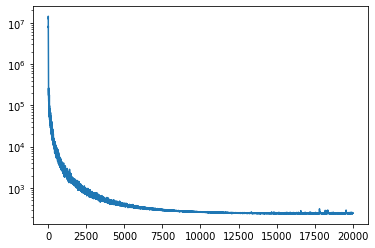

In [18]:
plt.semilogy(losses);

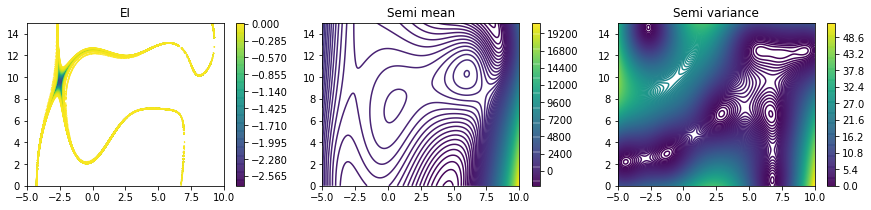

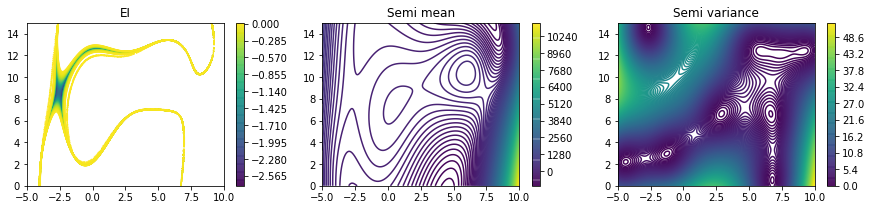

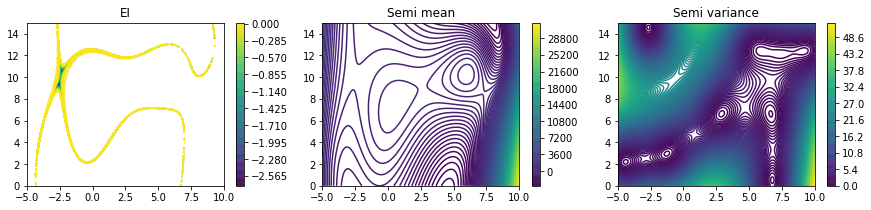

In [19]:
for i in range(3):
    plt.figure(figsize=(15, 3)) 

    with torch.no_grad(), semi_model_svi._pyro_context:
        plt.subplot(1,3,1)
        plt.title("EI")
        f = lambda x: acquisition_func(semi_model_svi, x)
#         plt.title("LCB")
#         f = lambda x: lower_confidence_bound(semi_model_svi, x)
        plot_obj(f)

        plt.subplot(1,3,2)
        plt.title("Semi mean")
        f = lambda x: semi_model_svi(x)[0]
        plot_obj(f)

        plt.subplot(1,3,3)
        plt.title("Semi variance")
        f = lambda x: semi_model_svi(x)[1]
        plot_obj(f)

In [ ]:
semi_model_svi(torch.tensor([2.5, 7.5]).unsqueeze(0))

In [ ]:
predictive = pyro.infer.Predictive(semi_model_svi, guide=semi_model_svi_guide, num_samples=10, return_sites=('y',))

with torch.no_grad():
    plot_function(lambda X: predictive(X)['y'].mean(0), n_points=1000)

In [37]:
pyro.clear_param_store()

class ParametricMeanFn(PyroModule):
    
    def __init__(self):
        super().__init__()
        self.alpha = PyroSample(dist.Uniform(0, 20))
        self.beta = PyroSample(dist.Uniform(0, 20))
        self.gamma = PyroSample(dist.Uniform(0, 20))
        
    def forward(self, X):
        x1 = X[...,0]
        x2 = X[...,1]
        return self.alpha*torch.cos(x1) + self.beta*torch.pow(x1, 4) + torch.pow(x2, 2) + self.gamma


class SemiParametricModel(PyroModule):

    def __init__(self, X, y, parametric_mean):
        """ Defines a semi-parametric model, where the `parametric_mean` is a `PyroModule` """
        super().__init__()
        self.parametric_mean = parametric_mean
        self.X = X
        self.y = y
        
        # Define GP (to be used for residual)
        self.kernel = gp.kernels.Matern52(input_dim=X.shape[1], lengthscale=100*torch.ones(X.shape[1]))
        self.gp = gp.models.GPRegression(X, y, self.kernel) 
        self.gp.kernel.lengthscale = PyroSample(dist.Uniform(0, 15).expand([2]).to_event())
        self.gp.kernel.variance = PyroSample(dist.Uniform(0, 200))
        self.gp.noise = PyroSample(dist.Uniform(0, 1))

    @pyro.nn.pyro_method
    def model(self):
        # Model definition code: explicitly subtract out the parametric mean, then call gp.model
        self.gp.set_data(self.X, self.y - self.parametric_mean(self.X))
        return self.gp.model()
        
    def forward(self, X):
        ''' Predict on new data points '''
        # reset "data" of GP to reflect mean estimate
        self.gp.set_data(self.X, self.y - self.parametric_mean(self.X))
        # sample mu, sigma
        mu, sigma = self.gp(X)
        # sample value of y
        y_hat = mu + self.parametric_mean(X)
        pyro.sample('y', dist.Normal(y_hat, sigma))
        # return the mean, in case we want to ignore the GP noise for some reason later
        return y_hat, sigma 

    
# Define the semiparametric model, and use an appropriate autoguide
semiparametric = SemiParametricModel(X_train, y_train, ParametricMeanFn())
guide = autoguide.AutoMultivariateNormal(semiparametric.model)

# Check:
guide()

{'parametric_mean.alpha': tensor(11.6790, grad_fn=<ExpandBackward>),
 'parametric_mean.beta': tensor(11.1987, grad_fn=<ExpandBackward>),
 'parametric_mean.gamma': tensor(13.4706, grad_fn=<ExpandBackward>),
 'gp.kernel.lengthscale': tensor([8.7829, 9.3799], grad_fn=<ExpandBackward>),
 'gp.kernel.variance': tensor(116.4408, grad_fn=<ExpandBackward>),
 'gp.noise': tensor(0.3228, grad_fn=<ExpandBackward>)}

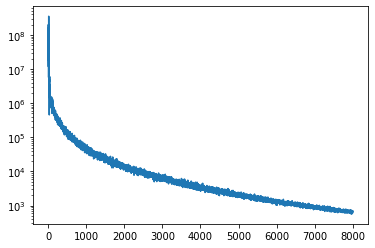

In [38]:
opt = pyro.optim.Adam({'lr': 0.1})
loss = Trace_ELBO()
svi = SVI(semiparametric.model, guide, opt, loss)

losses = []
for _ in range(8000):
    losses.append(svi.step())

plt.semilogy(losses)

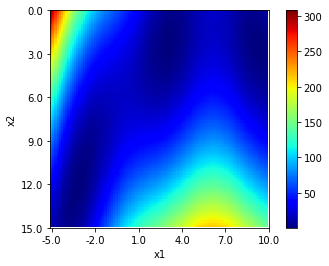

In [39]:

def plot_function(f, n_points=100):
    XX, YY = np.meshgrid(np.linspace(-5, 10, n_points), np.linspace(0, 15, n_points))
    ZZ = f(torch.FloatTensor(np.stack([XX.ravel(), YY.ravel()]).T))
    plt.imshow(ZZ.reshape(n_points, n_points));
    plt.xticks(np.linspace(0, n_points, 6), np.linspace(-5, 10, 6))
    plt.yticks(np.linspace(0, n_points, 6), np.linspace(0, 15, 6))
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.set_cmap('jet')
    plt.colorbar()

plt.figure(figsize=(6,4))
plot_function(branin_hoo)

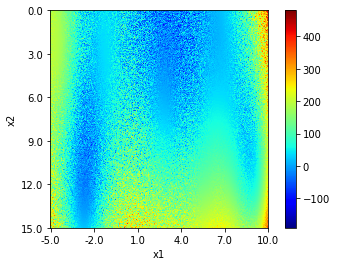

In [40]:
predictive = pyro.infer.Predictive(semiparametric, guide=guide, num_samples=10, return_sites=('y',))

with torch.no_grad():
    plot_function(lambda X: predictive(X)['y'].mean(0), n_points=1000)

In [41]:
print(predictive(torch.tensor([2.5, 7.5]).unsqueeze(0))['y'].mean(0))

tensor([31.8293], grad_fn=<MeanBackward1>)


In [42]:
predictive(torch.tensor([2.5, 7.5]).unsqueeze(0))

{'y': tensor([[52.8542],
         [45.1245],
         [29.7049],
         [20.2978],
         [74.9264],
         [40.8126],
         [38.9081],
         [22.7268],
         [22.9011],
         [67.7527]], grad_fn=<AsStridedBackward>)}

In [46]:
def plot_obj(obj_function):

    steps = 1000
    strides = 200

    X1 = torch.linspace(const_x1_min, const_x1_max, steps)
    X2 = torch.linspace(const_x2_min, const_x2_max, steps)

    X1_mesh, X2_mesh = torch.meshgrid(X1, X2)
    
    Z_mesh = obj_function(torch.stack((X1_mesh.flatten(), X2_mesh.flatten()), dim=1)).reshape(steps, steps)
    plt.contour(
        X1_mesh.detach().numpy(), 
        X2_mesh.detach().numpy(), 
        Z_mesh.detach().numpy(), strides)
    
    plt.colorbar()

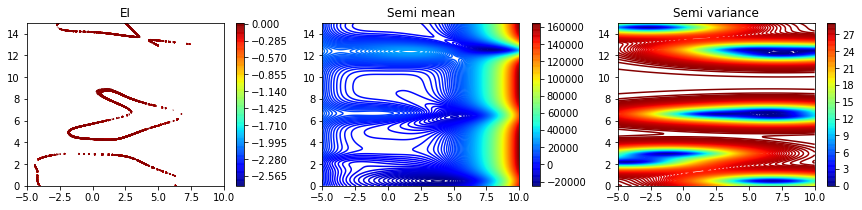

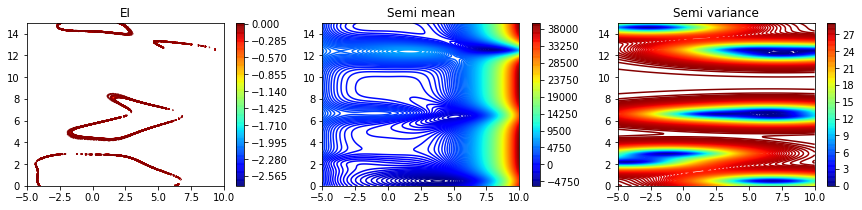

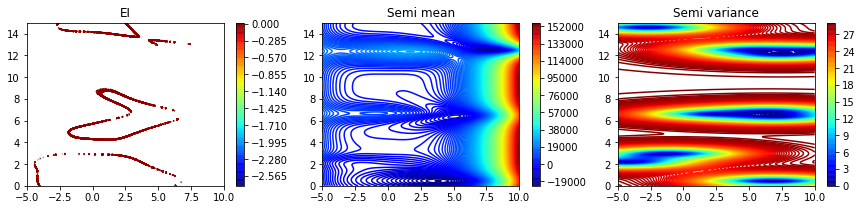

In [47]:
for i in range(3):
    plt.figure(figsize=(15, 3)) 

    with torch.no_grad(), semiparametric._pyro_context:
        plt.subplot(1,3,1)
        plt.title("EI")
        f = lambda x: acquisition_func(semiparametric, x)
        plot_obj(f)

        plt.subplot(1,3,2)
        plt.title("Semi mean")
        f = lambda x: semiparametric(x)[0]
        plot_obj(f)

        plt.subplot(1,3,3)
        plt.title("Semi variance")
        f = lambda x: semiparametric(x)[1]
        plot_obj(f)

In [53]:
semiparametric.parametric_mean(torch.tensor([[2.5, 7.5]]))

tensor([303.6974])

In [ ]:
sbo_tests_closest_points = []
sbo_tests_search_points = []

for test_i in range(num_tests):
    print("TEST: ", test_i+1)
    try:
        pyro.clear_param_store()

        # initial training of the model
        semi_model_svi = SemiParametricModel(X_train, y_train, ParametricMeanFn())
        _, _ = train(semi_model_svi, num_steps=adam_num_steps)

        xmins = []

        for i in range(bo_steps):

            xmin = next_x(semi_model_svi, constr, 
                          num_candidates=num_candidates, num_steps=adam_num_steps)

            update_posterior(semi_model_svi, branin_hoo, xmin, 
                             num_steps=adam_num_steps, adam_params=adam_params)

            xmins.append(xmin)
            
            closest_point, closest_dist = find_best_solution([xmin], branin_hoo_lms)
            
            print("  SBO STEP: ", i+1, "xmin:", xmin, 
                  "  Best candidate: ", closest_point, " distance: ", closest_dist)

        closest_point, closest_dist = find_best_solution(xmins, branin_hoo_lms)

        print("  Best candidate: ", closest_point, " distance: ", closest_dist)

        sbo_tests_closest_points.append(closest_point)
        sbo_tests_search_points.append(xmins)
    except:
        sbo_tests_closest_points.append(None)
        sbo_tests_search_points.append(None)
        
        continue

## RANDOM approach

In [ ]:
def next_x_random():
    """ Randomly generates new point to be added to the optimisation """
    
    return torch.rand(1, 2)*15 + torch.FloatTensor([const_x1_min, const_x2_min])

In [ ]:
best_random_points = []

for test_i in range(num_tests):
    print("TEST: ", test_i+1)
    
    xmins = []

    for i in range(bo_steps):
        print("  RANDOM STEP: ", i+1)

        xmin = next_x_random()

        xmins.append(xmin)

    closest_point, closest_dist = find_best_solution(xmins, branin_hoo_lms)

    print("  Best candidate: ", closest_point, " distance: ", closest_dist)

    best_random_points.append(closest_point)

# Comparison

In [ ]:
print("Best BO: ", find_best_solution(best_bo_points, branin_hoo_lms))
print("Best SBO: ", find_best_solution(best_sbo_points, branin_hoo_lms))
print("Best RANDOM: ", find_best_solution(best_random_points, branin_hoo_lms))